In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

# The path to the lumapi.py file
file_path = 'C:\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py'
spec_win = importlib.util.spec_from_file_location('lumapi', file_path)
lumapi = importlib.util.module_from_spec(spec_win)
spec_win.loader.exec_module(lumapi)



<>:7: SyntaxWarning: invalid escape sequence '\P'
<>:7: SyntaxWarning: invalid escape sequence '\P'
C:\Users\dhwanilp\AppData\Local\Temp\ipykernel_18744\1323305641.py:7: SyntaxWarning: invalid escape sequence '\P'
  file_path = 'C:\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py'


In [2]:
def vertexC(Ax, Ay, Bx, By, angleA, angleB, height):

    angleA = angleA * np.pi / 180; angleB = angleB * np.pi / 180

    # Calculate the third side and angle 
    u = Bx - Ax; v = By - Ay
    AB = np.sqrt(u**2 + v**2)
    angleC = np.pi - angleA - angleB; BC = AB * np.sin(angleB) / np.sin(angleC)

    # Compute RHS components for Cx and Cy
    RHS1 = Ax * u + Ay * v + BC * AB * np.cos(angleA)
    RHS2 = By * u - Bx * v - BC * AB * np.sin(angleA)

    # Compute Cx and Cy
    Cx = (1 / AB**2) * (u * RHS1 - v * RHS2); Cy = (1 / AB**2) * (v * RHS1 + u * RHS2)
    C_vertex = [Cx, Cy]
    return Cx, Cy

def mthorder_angle(arr, m):
    # Convert to numpy array for easier handling
    arr = np.array(arr)
    if m < 0:
        #print(arr[np.where(arr < 0)[0]])
        #print(arr[np.where(arr < 0)[0]][m])
        return np.where(arr == arr[np.where(arr < 0)[0]][m])[0][0]
    if m == 0:
        #print(arr[np.where(arr == 0)[0]])
        #print(arr[np.where(arr == 0)[0]][m])
        return np.where(arr == arr[np.where(arr == 0)[0]][m])[0][0]
    if m > 0:
        #print(arr[np.where(arr > 0)[0]])
        #print(arr[np.where(arr > 0)[0]][m-1])
        return np.where(arr == arr[np.where(arr > 0)[0]][m - 1])[0][0]
    

In [3]:

def immersed_grating_fdtd(wavelength, pol, period_grating, base_width, height, angleB, angleA, incidence_angle):
    """
    
    """
    # Initialize FDTD
    fdtd = lumapi.FDTD(hide=True)

    fdtd.switchtolayout()
    fdtd.deleteall()

    z_span = 0e-6  # z thickness
    num_triangles = 2  # Number of triangles to create
    coating_thickness = 200e-9  # Coating thickness [m]
    Ax, Ay = 0, 0
    Bx, By = base_width + Ax, 0

    # Calculate the vertex of point C
    Cx, Cy = vertexC(Ax, Ay, Bx, By, angleA, angleB, height)

    # Calculate the vertex of point C
    Cx, Cy = vertexC(Ax, Ay, Bx, By, angleA, angleB, height)

    # Add structure groups
    fdtd.addstructuregroup()
    fdtd.set("name", "coating")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "etch")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "coatingSlab")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "etchSlab")
    fdtd.set("enabled", 1)

    # Loop to create multiple triangles
    for n in range(1, num_triangles + 1):
        if n == np.ceil(num_triangles / 2):
            center_x = Cx
            center_y = Cy
        
        # Prepare vertices array
        vtx = np.array([[Ax, Ay], [Bx, By], [Cx, Cy]])

        # Add the triangle for coating
        fdtd.addtriangle()
        fdtd.set('name', 'coating' + str(n))
        fdtd.set('x', 0)
        fdtd.set('y', 0)
        fdtd.set('vertices', vtx)
        fdtd.set('z span', z_span)
        fdtd.set('material', 'Al (Aluminium) - Palik')
        fdtd.addtogroup("coating")
        
        vtx = np.array([[Ax, Ay + coating_thickness], [Bx, By + coating_thickness], [Cx, Cy + coating_thickness]])
        # Add the triangle for etch
        fdtd.addtriangle()
        fdtd.set('name', 'etch' + str(n))
        fdtd.set('x', 0)
        fdtd.set('y', 0)
        fdtd.set('vertices', vtx)
        fdtd.set('z span', z_span)
        fdtd.set('material', 'etch')
        fdtd.addtogroup("etch")
        
        Ax = Bx + (period_grating - base_width)
        Ay = 0
        Bx = Ax + base_width
        By = 0
        Cx = period_grating + Cx

    # Add rectangular coating
    fdtd.addrect()
    fdtd.set('name', 'coating-slab')
    fdtd.set('x min', 0)
    fdtd.set('y min', 0)
    fdtd.set('x max', period_grating * num_triangles)
    fdtd.set('y max', coating_thickness * 2)
    fdtd.set('z span', z_span)
    fdtd.set('material', 'Al (Aluminium) - Palik')
    fdtd.addtogroup("coatingSlab")

    # Add rectangular etch
    fdtd.addrect()
    fdtd.set('name', 'etch-slab')
    fdtd.set('x min', 0)
    fdtd.set('y min', 0 + coating_thickness / 2)
    fdtd.set('x max', period_grating * num_triangles)
    fdtd.set('y max', coating_thickness * 10)
    fdtd.set('z span', z_span)
    fdtd.set('material', 'etch')
    fdtd.addtogroup("etchSlab")

    fdtd.copymaterial('Si (Silicon) - Palik');
    fdtd.setmaterial('Si (Silicon) - Palik Copy 1', "mesh", 3);

    # Add rectangular substrate
    width = period_grating * num_triangles
    height = 2 * period_grating
    fdtd.addrect()
    fdtd.set('name', 'grating1')
    fdtd.set('x', width / 2)
    fdtd.set('y', -height / 2)
    fdtd.set('x span', width)
    fdtd.set('y span', height * 2)
    fdtd.set('z span', z_span)
    fdtd.set('material', 'Si (Silicon) - Palik Copy 1')

    # Setup and add monitors
    fdtd.addindex()
    fdtd.set("name", "index_monitor")
    fdtd.set("monitor type", 3)  # 2D z-normal
    fdtd.set('x', width / 2)
    fdtd.set('y', -height / 2)
    fdtd.set('x span', width / (0.5 * num_triangles))
    fdtd.set('y span', height * 1.3)

    fdtd.addmovie()
    fdtd.set("name", "ig_movie")
    fdtd.set("monitor type", 3)  # 2D z-normal
    fdtd.set('x', width / 2)
    fdtd.set('y', -height / 2)
    fdtd.set('x span', width / (0.5 * num_triangles))
    fdtd.set('y span', height * 1.3)
    fdtd.set('field component', 'Ex')
    fdtd.set('TM field component', 'Hx')
    fdtd.set('TE field component', 'Ey')
    fdtd.set("lock aspect ratio", 1)
    fdtd.set("horizontal resolution", 240)

    # Add FDTD region
    fdtd.addfdtd()
    width = period_grating * num_triangles
    height = 2 * period_grating
    fdtd.set('x', width / 2)
    fdtd.set('y', -height / 2)
    fdtd.set('dimension','2D')
    fdtd.set('x span', width)
    fdtd.set('y span', height * 1.3)
    fdtd.set('x min bc', 'Bloch')

    fdtd.set('z', 0);  # Center position in z
    fdtd.set('z span', z_span/10)  # Width in z-dimension

    # Set up a source
    fdtd.addplane()
    source_offset_y = -height / 1.5  # [m]
    source_offset_x = 0.0e-6  # [m]
    fdtd.set('injection axis', 'y')
    fdtd.set('x', center_x + source_offset_x)
    fdtd.set('y', center_y + source_offset_y)
    fdtd.set('angle', incidence_angle)
    fdtd.set('polarization angle', pol)
    fdtd.set('plane wave type', 'Bloch/periodic')
    fdtd.set('wavelength start', wavelength)
    fdtd.set('wavelength stop', wavelength)

    # Add monitors to measure power transmitted and reflected
    fdtd.addpower()
    fdtd.set("name", "transmission_grating")
    fdtd.set("monitor type", "2D z-normal")
    fdtd.set('x', width / 2)
    fdtd.set('y', 0.05 * height)
    fdtd.set('x span', 1.5 * (width / (0.5 * num_triangles)))
    fdtd.set('y span', height * 0)

    fdtd.addpower()
    fdtd.set("name", "reflection_grating")
    fdtd.set("monitor type", "2D z-normal")
    fdtd.set('x', width / 2)
    fdtd.set('y', -height * 1.1)
    fdtd.set('x span', 1.5 * (width / (0.5 * num_triangles)))
    fdtd.set('y span', height * 0)


    # Run the simulation
    filename = 'swir_3_field' +  f"{pol}" + f"{wavelength*1e6}" + ".fsp"
    fdtd.save(filename)
    index_profile = fdtd.getresult("index_monitor","index")
        
    # Run the simulation
    run_switch = 1
    if run_switch == 1:
        fdtd.run()
        
        T_R = fdtd.getresult("reflection_grating", "T")
        T_T = fdtd.getresult("transmission_grating", "T")
        f = fdtd.getdata("reflection_grating", "f")
        Tr = fdtd.transmission("reflection_grating", 1)
        Tt = fdtd.transmission("transmission_grating", 1)
        
        mname = "reflection_grating"  # monitor name
        theta = fdtd.gratingangle(mname)  # angle of each grating order
        N = fdtd.gratingn(mname)  # r
        G = fdtd.grating(mname)  # power to each order (fraction of transmitted power)
        
        return np.array(theta), np.array(-Tr * G), index_profile
    else:
        return np.zeros([1,2]), np.zeros([1,2]), index_profile



In [4]:
# parameters for Sentinel-V SWIR - 3
grating_params = {
    "period_grating": 2070e-9,  # Period of grating [m]
    "base_width": 1690e-9,      # Base width of etch [m]
    "height": 1194e-9,          # Height of the etch [m]
    "angleB": 53.5,             # Angle B in degrees
    "angleA": 56,               # Angle A in degrees
    "incidence_angle": -62.5
    }

wavelength_i = 2.345e-6
pol_angle=0

theta, eff, index_profile = immersed_grating_fdtd(wavelength_i, pol_angle, **grating_params)

C:\Program Files\Lumerical\v241\api\python\lumapi.py:895: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


KeyboardInterrupt: 

In [5]:
(7 * 3 * 39.4)/60

13.79

In [ ]:


# %%
wavelength_range = np.array([2.304e-6, 2.345e-6, 2.386e-6])
wavelength_range = np.linspace(2.304e-6, 2.400e-6, 7)
pol = 0

theta_arr = []
eff_arr = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i,_ = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr.append(theta_arr_i[:,0])
    eff_arr.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



pol = 90

theta_arr_90 = []
eff_arr_90 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i,_ = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_90.append(theta_arr_i[:,0])
    eff_arr_90.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



pol = 45

theta_arr_45 = []
eff_arr_45 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i, _ = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_45.append(theta_arr_i[:,0])
    eff_arr_45.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



done: wav = 2.304 microns
done: wav = 2.32 microns
done: wav = 2.336 microns
done: wav = 2.352 microns
done: wav = 2.368 microns
done: wav = 2.384 microns
done: wav = 2.4 microns
done: wav = 2.304 microns
done: wav = 2.32 microns
done: wav = 2.336 microns
done: wav = 2.352 microns
done: wav = 2.368 microns
done: wav = 2.384 microns
done: wav = 2.4 microns
done: wav = 2.304 microns
done: wav = 2.32 microns
done: wav = 2.336 microns
done: wav = 2.352 microns
done: wav = 2.368 microns
done: wav = 2.384 microns
done: wav = 2.4 microns


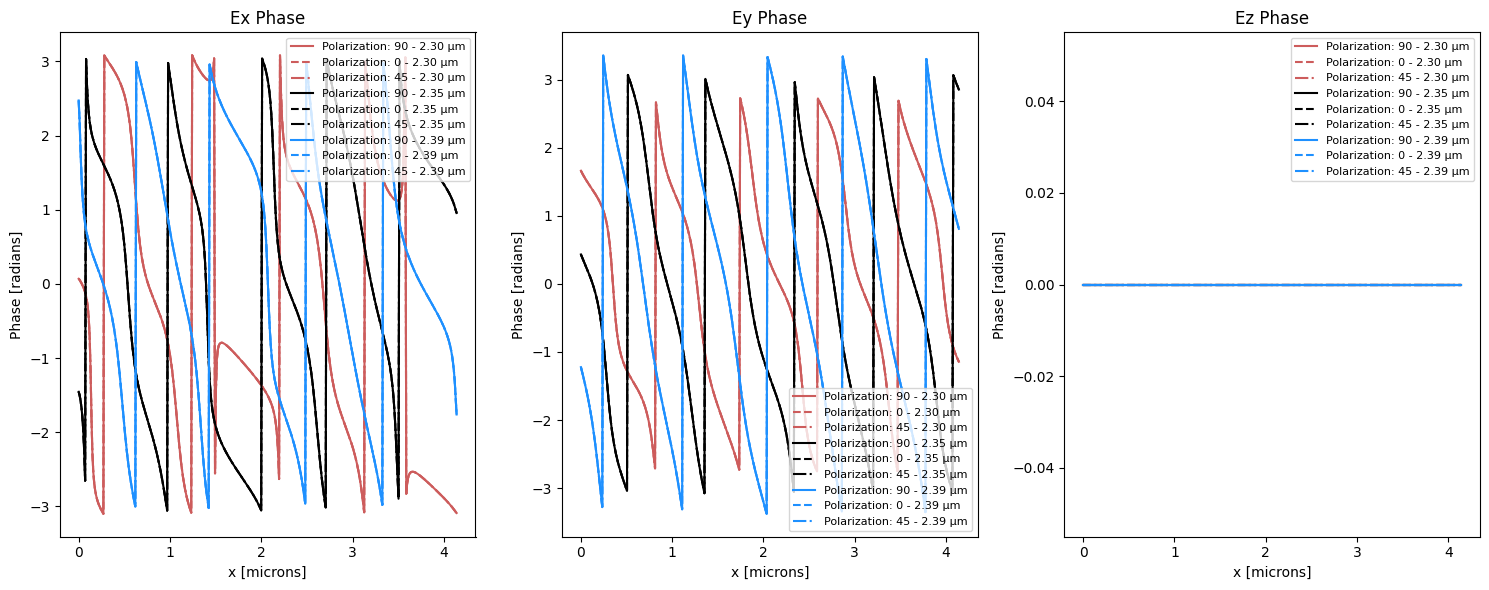

In [37]:
import matplotlib.pyplot as plt
import numpy as np

wavelengths = [2.304e-6, 2.345e-6, 2.386e-6]
polarizations = [90, 0, 45]
colors = ['indianred', 'black', 'dodgerblue']
linestyles = ['-', '--', '-.']

# Create a single figure for all subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Loop over each wavelength and polarization
for i, wavelength_i in enumerate(wavelengths):
    for j, polarisation in enumerate(polarizations):
        # Construct filename and FDTD run
        filename = 'swir_3_field' +  f"{pol_angle}" + f"{wavelength_i*1e6}" + ".fsp"
        fdtd = lumapi.FDTD(filename, hide=True)

        fdtd.run("FDTD")

        mnmae = 'reflection_grating'
        Ex_mon = fdtd.getdata(mnmae, "Ex")
        Ey_mon = fdtd.getdata(mnmae, "Ey")
        Ez_mon = fdtd.getdata(mnmae, "Ez")

        # Extract data
        x_arr = fdtd.getdata(mnmae, "x")
        z_arr = fdtd.getdata(mnmae, "z")

        x = x_arr[:,0]

        # Select data for the polarization
        Ex = Ex_mon[:,0,:,0]
        Ey = Ey_mon[:,0,:,0]
        Ez = Ez_mon[:,0,:,0]

        # Plot phase along x for the selected polarization in separate subplots

        weight_Ex_phase = np.mean(2 * np.abs(Ex)[:, 0]) * np.angle(Ex)[:, 0]
        weight_Ey_phase = np.mean(2 * np.abs(Ey)[:, 0]) * np.angle(Ey)[:, 0]
        weight_Ez_phase = np.mean(2 * np.abs(Ez)[:, 0]) * np.angle(Ez)[:, 0]

        axs[0].plot(x*1e6, weight_Ex_phase, label=f"Polarization: {polarisation} - {wavelength_i*1e6:.2f} µm", color=colors[i], linestyle=linestyles[j])
        axs[1].plot(x*1e6, weight_Ey_phase, label=f"Polarization: {polarisation} - {wavelength_i*1e6:.2f} µm", color=colors[i], linestyle=linestyles[j])
        axs[2].plot(x*1e6, weight_Ez_phase, label=f"Polarization: {polarisation} - {wavelength_i*1e6:.2f} µm", color=colors[i], linestyle=linestyles[j])

# Customize the subplots
axs[0].set_title('Ex Phase')
axs[1].set_title('Ey Phase')
axs[2].set_title('Ez Phase')

# Set common labels
for ax in axs:
    ax.set_xlabel("x [microns]")
    ax.set_ylabel("Phase [radians]")
    ax.legend(fontsize=8)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [16]:
# Initialize an empty dictionary to store the data
E_dict = {}

wavelengths = [2.304e-6, 2.345e-6, 2.386e-6]
wavelengths = np.linspace(2.304e-6, 2.400e-6, 7)
polarizations = [90, 0, 45]

# Loop over each wavelength and polarization
for i, wavelength_i in enumerate(wavelengths):
    for j, polarisation in enumerate(polarizations):
        # Construct filename and FDTD run
        filename = 'swir_3_field' +  f"{polarisation}" + f"{wavelength_i*1e6}" + ".fsp"
        fdtd = lumapi.FDTD(filename, hide=True)

        fdtd.run("FDTD")

        mnmae = 'reflection_grating'
        Ex_mon = fdtd.getdata(mnmae, "Ex")
        Ey_mon = fdtd.getdata(mnmae, "Ey")
        Ez_mon = fdtd.getdata(mnmae, "Ez")

        # Extract data
        x_arr = fdtd.getdata(mnmae, "x")
        z_arr = fdtd.getdata(mnmae, "z")

        x = x_arr[:,0]

        # Select data for the polarization
        Ex = Ex_mon[:,0,:,0]
        Ey = Ey_mon[:,0,:,0]
        Ez = Ez_mon[:,0,:,0]

        weight_Ex_phase = np.mean(2 * np.abs(Ex)[:, 0]) * np.angle(Ex)[:, 0]
        weight_Ey_phase = np.mean(2 * np.abs(Ey)[:, 0]) * np.angle(Ey)[:, 0]
        weight_Ez_phase = np.mean(2 * np.abs(Ez)[:, 0]) * np.angle(Ez)[:, 0]

        weight_Ex_phase = np.angle(Ex)[:, 0]
        weight_Ey_phase = np.angle(Ey)[:, 0]
        weight_Ez_phase = np.angle(Ez)[:, 0]

        # Store the weighted phase data in the dictionary with the appropriate key
        E_dict[f'E_x_{int(wavelength_i*1e9)}_{polarisation}'] = weight_Ex_phase
        E_dict[f'E_y_{int(wavelength_i*1e9)}_{polarisation}'] = weight_Ey_phase
        E_dict[f'E_z_{int(wavelength_i*1e9)}_{polarisation}'] = weight_Ez_phase

        print(filename)

swir_3_field902.304.fsp
swir_3_field02.304.fsp
swir_3_field452.304.fsp
swir_3_field902.32.fsp
swir_3_field02.32.fsp
swir_3_field452.32.fsp
swir_3_field902.336.fsp
swir_3_field02.336.fsp
swir_3_field452.336.fsp
swir_3_field902.352.fsp
swir_3_field02.352.fsp
swir_3_field452.352.fsp
swir_3_field902.368.fsp
swir_3_field02.368.fsp
swir_3_field452.368.fsp
swir_3_field902.384.fsp
swir_3_field02.384.fsp
swir_3_field452.384.fsp
swir_3_field902.4.fsp
swir_3_field02.4.fsp
swir_3_field452.4.fsp


<>:96: SyntaxWarning: invalid escape sequence '\P'
<>:96: SyntaxWarning: invalid escape sequence '\P'
C:\Users\dhwanilp\AppData\Local\Temp\ipykernel_18744\3414141919.py:96: SyntaxWarning: invalid escape sequence '\P'
  '''plt.savefig('eff_dispersion_swir3_m5.png', dpi=1000)


"plt.savefig('eff_dispersion_swir3_m5.png', dpi=1000)\n#plt.savefig('eff_dispersion_swir3_allm.png', dpi=1000)\n\nsave_path = r'\\tsclient\\PHIGS\\paper'\nos.makedirs(save_path, exist_ok=True)  # This ensures the directory exists\n\n#plt.savefig(os.path.join(save_path, 'eff_dispersion_swir3_allm.png'), dpi=1000)\nplt.savefig(os.path.join(save_path, 'eff_dispersion_swir3_m5.png'), dpi=1000)"

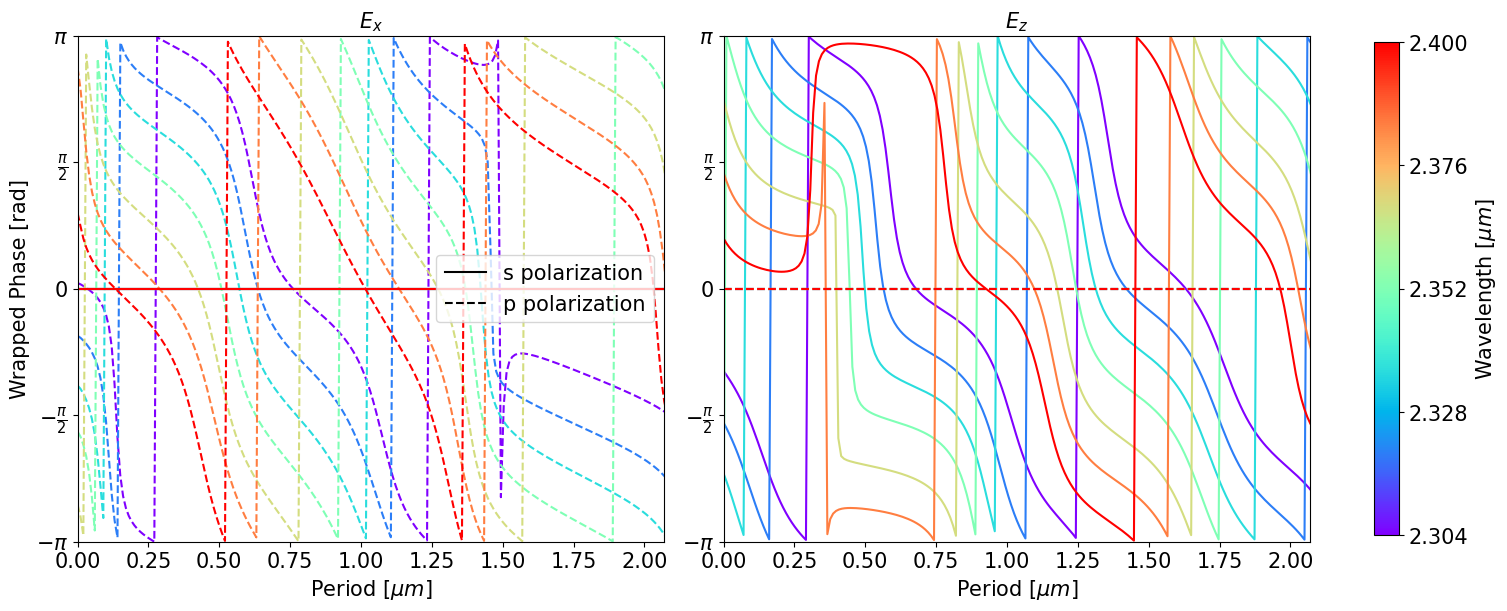

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

wavelengths_interested = wavelengths #np.array([wavelengths[0], wavelengths[len(wavelengths)//2], wavelengths[-1]])
wavelengths_nm = wavelengths_interested * 1e9
wavelengths_m = wavelengths_interested

# Extend linestyle map to include 'u' with dotted line
linestyles = {'90': '-', '0': '--', '45': ':'}
polarizations = [0, 90]

# Update list of polarizations if 'u' is also present
#polarizations = sorted({k.split('_')[3] for k in E_dict.keys()})

# Recreate colormap and normalization for 'rainbow'
cmap = cm.rainbow
norm = mcolors.Normalize(vmin=wavelengths_m.min(), vmax=wavelengths_m.max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)


# Define a central fontsize variable
fontsize = 15
# Create figure with constrained layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# Plot E_x
ax = axs[0]
for wl_nm in wavelengths_nm:
    for pol in polarizations:
        key = f'E_x_{int(wl_nm)}_{pol}'
        if key in E_dict:
            y = E_dict[key]
            y_wrapped = (y + np.pi) % (2 * np.pi) - np.pi
            x = np.linspace(0, 2 * 2.07, len(y))
            ax.plot(x, y_wrapped,
                    color=cmap(norm(wl_nm * 1e-9)),
                    linestyle=linestyles.get(str(pol), '-'))
ax.set_title(r'$E_x$', fontsize=fontsize)
ax.set_xlabel(r'Period [$\mu m$]', fontsize=fontsize)
ax.set_ylabel('Wrapped Phase [rad]', fontsize=fontsize)
ax.set_xlim(0, 2.07)
ax.set_ylim(-np.pi, np.pi)
ax.tick_params(labelsize=fontsize)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=np.pi / 2))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: {
    -np.pi: r'$-\pi$',
    -np.pi / 2: r'$-\frac{\pi}{2}$',
    0: r'$0$',
    np.pi / 2: r'$\frac{\pi}{2}$',
    np.pi: r'$\pi$'
}.get(val, f'{val:.2f}')))

# Plot E_z
ax = axs[1]
for wl_nm in wavelengths_nm:
    for pol in polarizations:
        key = f'E_z_{int(wl_nm)}_{pol}'
        if key in E_dict:
            y = E_dict[key]
            y_wrapped = (y + np.pi) % (2 * np.pi) - np.pi
            x = np.linspace(0, 2 * 2.07, len(y))
            ax.plot(x, y_wrapped,
                    color=cmap(norm(wl_nm * 1e-9)),
                    linestyle=linestyles.get(str(pol), '-'))
ax.set_title(r'$E_z$', fontsize=fontsize)
ax.set_xlabel(r'Period [$\mu m$]', fontsize=fontsize)
ax.set_xlim(0, 2.07)
ax.set_ylim(-np.pi, np.pi)
ax.tick_params(labelsize=fontsize)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=np.pi / 2))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: {
    -np.pi: r'$-\pi$',
    -np.pi / 2: r'$-\frac{\pi}{2}$',
    0: r'$0$',
    np.pi / 2: r'$\frac{\pi}{2}$',
    np.pi: r'$\pi$'
}.get(val, f'{val:.2f}')))

# Add legend for polarizations
legend_lines = [
    Line2D([], [], color='black', linestyle='-', label='s polarization'),
    Line2D([], [], color='black', linestyle='--', label='p polarization'),
]
axs[0].legend(handles=legend_lines, loc='center right', fontsize=fontsize)

# Add colorbar
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.05)
cbar.set_label(r'Wavelength [$\mu m$]', fontsize=fontsize)
tick_locs = np.linspace(wavelengths_m.min(), wavelengths_m.max(), 5)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([f"{(tick * 1e6):.03f}" for tick in tick_locs])
cbar.ax.tick_params(labelsize=fontsize)

'''plt.savefig('eff_dispersion_swir3_m5.png', dpi=1000)
#plt.savefig('eff_dispersion_swir3_allm.png', dpi=1000)

save_path = r'\\tsclient\PHIGS\paper'
os.makedirs(save_path, exist_ok=True)  # This ensures the directory exists

#plt.savefig(os.path.join(save_path, 'eff_dispersion_swir3_allm.png'), dpi=1000)
plt.savefig(os.path.join(save_path, 'eff_dispersion_swir3_m5.png'), dpi=1000)'''


<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
C:\Users\dhwanilp\AppData\Local\Temp\ipykernel_27728\1640682072.py:27: SyntaxWarning: invalid escape sequence '\m'
  '''# Ey


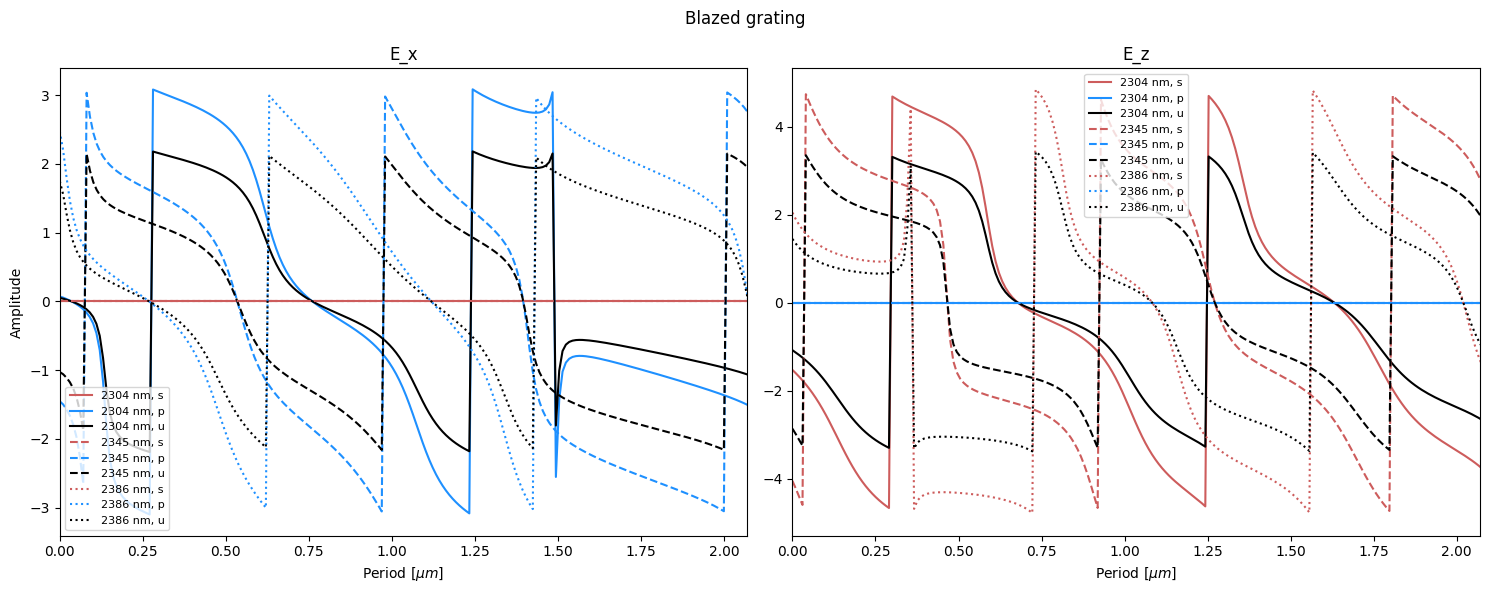

In [64]:
import matplotlib.pyplot as plt

wavelengths = ['2304', '2345', '2386']
polarizations = ['90', '0', '45']
colors = {'90': 'indianred', '0': 'dodgerblue', '45': 'k'}
linestyles = {'2304': '-', '2345': '--', '2386': ':'}

pol_lab = ['s', 'p', 'u']
plt.figure(figsize=(15, 6))

plt.suptitle(f'Blazed grating')
# Ex
plt.subplot(1, 2, 1)
for wl in wavelengths:
    for i_pol, pol in enumerate(polarizations):
        x = np.linspace(x[0], x[-1], len(E_dict[f'E_x_{wl}_{pol}']))
        plt.plot(x*1e6, E_dict[f'E_x_{wl}_{pol}'], 
                 label=f'{wl} nm, {pol_lab[i_pol]}', 
                 color=colors[pol], 
                 linestyle=linestyles[wl])
plt.title('E_x')
plt.xlabel(r'Period [$\mu m$]')
plt.ylabel('Amplitude')
plt.legend(fontsize=8)
plt.xlim(0, 2.07)

'''# Ey
plt.subplot(1, 3, 2)
for wl in wavelengths:
    for pol in polarizations:
    x = np.linspace(x[0], x[-1], len(E_dict[f'E_y_{wl}_{pol}']))
        plt.plot(x*1e6, E_dict[f'E_y_{wl}_{pol}'], 
                 label=f'{wl} nm, {pol}', 
                 color=colors[pol], 
                 linestyle=linestyles[wl])
plt.title('E_y')
plt.xlabel(r'Period [$\mu m$]')
plt.legend(fontsize=8)'''

# Ez
plt.subplot(1, 2, 2)
for wl in wavelengths:
    for i_pol, pol in enumerate(polarizations):
        x = np.linspace(x[0], x[-1], len(E_dict[f'E_z_{wl}_{pol}']))
        plt.plot(x*1e6, E_dict[f'E_z_{wl}_{pol}'], 
                 label=f'{wl} nm, {pol_lab[i_pol]}', 
                 color=colors[pol], 
                 linestyle=linestyles[wl])
plt.title('E_z')
plt.xlabel(r'Period [$\mu m$]')
plt.legend(fontsize=8)
plt.xlim(0, 2.07)

plt.tight_layout()
plt.show()


In [ ]:
######################################################################

In [ ]:
import numpy as np

# Convert lists to numpy objects with `dtype=object` to handle inhomogeneous shapes
np.savez_compressed('sawtooth_grating_data_opRange.npz',
                    wavelength_range=wavelength_range,
                    theta_arr_0=np.array(theta_arr, dtype=object),
                    eff_arr_0=np.array(eff_arr, dtype=object),
                    theta_arr_90=np.array(theta_arr_90, dtype=object),
                    eff_arr_90=np.array(eff_arr_90, dtype=object),
                    theta_arr_45=np.array(theta_arr_45, dtype=object),
                    eff_arr_45=np.array(eff_arr_45, dtype=object))


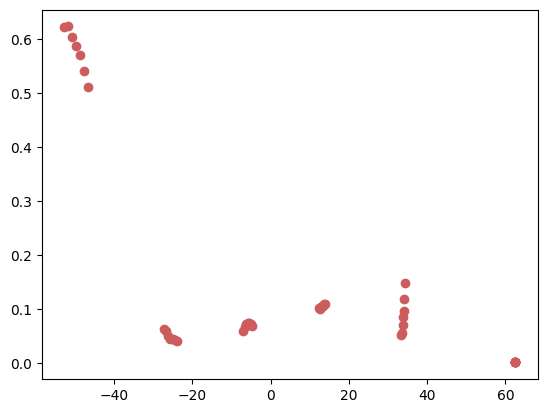

In [10]:
for i in range(len(theta_arr)):
    #plt.scatter(theta_arr_45[i], eff_arr_45[i], color = 'k', label = 'unpolarized')
    plt.scatter(theta_arr[i], eff_arr[i], color = 'indianred', label = 'TM')
    #plt.scatter(theta_arr_90[i], eff_arr_90[i], color = 'dodgerblue', label = 'TE')



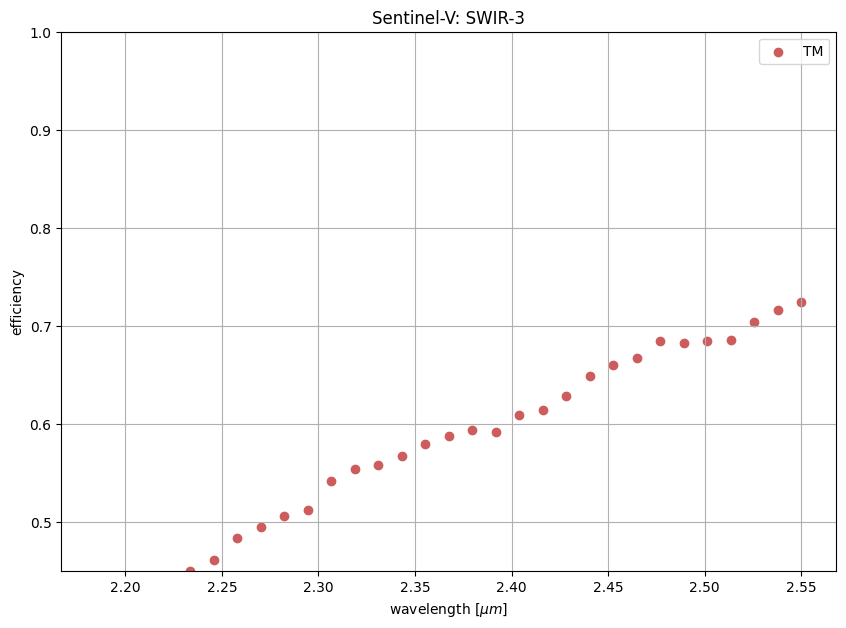

In [58]:

m=-5
eff_arr_mth = []
eff_arr_90_mth = []
eff_arr_45_mth = []
for i in range(len(wavelength_range)):
    eff_arr_mth.append(eff_arr[i][mthorder_angle(theta_arr[i], -4)])
    #eff_arr_90_mth.append(eff_arr_90[i][mthorder_angle(theta_arr[i], -5)])
    #eff_arr_45_mth.append(eff_arr_45[i][mthorder_angle(theta_arr[i], -5)])

plt.figure(figsize=(10, 7))
#plt.scatter(wavelength_range*1e6, eff_arr_45_mth, color = 'k', label = 'unpolarized')
plt.scatter(wavelength_range*1e6, eff_arr_mth, color = 'indianred', label = 'TM')
#plt.scatter(wavelength_range*1e6, eff_arr_90_mth, color = 'dodgerblue', label = 'TE')
plt.ylim(0.45,1.0)
plt.title(f"Sentinel-V: SWIR-3")
plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'efficiency')
plt.legend()
plt.grid()

In [57]:
eff_arr_mth

[0.40164657817019295,
 0.36953579964345884,
 1.4943635222034211e-05,
 2.9249502774056854e-14,
 3.395233831604354e-14,
 0.0001290716817788805,
 6.273865139514281e-16,
 0.00011409621720706374,
 0.00010905073066604847,
 9.676234446258124e-15,
 0.00021708265309256362,
 1.4854746488080755e-14,
 5.424145842078124e-05,
 2.2587470221808764e-16,
 5.0729114666056274e-05,
 5.530592382514812e-05,
 8.95851928306567e-15,
 0.00012292836643857584,
 2.7870170560263457e-15,
 2.773576176409617e-05,
 3.3604071116058173e-15,
 1.196817767109523e-05,
 4.92989968968541e-15,
 6.314333212322353e-06,
 2.278318742413178e-15,
 0.00010916196909752743,
 1.782810530116449e-05,
 1.2620020220027442e-16,
 6.995740721221038e-05,
 3.1746541827198682e-15,
 0.00014402141492700295]

In [ ]:
theta_arr_swir3_s5 = theta_arr
eff_arr_swir3_s5 = eff_arr

theta_arr_swir3_s5_90 = theta_arr_90
eff_arr_swir3_s5_90 = eff_arr_90

theta_arr_swir3_s5_45 = theta_arr_45
eff_arr_swir3_s5_45 = eff_arr_45

In [45]:
######## SWIR-1 Sentinel V ###############
# parameters for Sentinel-V SWIR - 1
grating_params = {
    "period_grating": 2070e-9,  # Period of grating [m]
    "base_width": 1670e-9,      # Base width of etch [m]
    "height": 1125e-9,          # Height of the etch [m]
    "angleB": 65,             # Angle B in degrees
    "angleA": 44.5,               # Angle A in degrees
    "incidence_angle": -50.41
    }


In [10]:
wavelength_range = np.linspace(1.590e-6, 1.675e-6, 21)
pol = 0
theta_arr = []
eff_arr = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr.append(theta_arr_i[:,0])
    eff_arr.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.590e-6, 1.675e-6, 7)
pol = 90

theta_arr_90 = []
eff_arr_90 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_90.append(theta_arr_i[:,0])
    eff_arr_90.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.590e-6, 1.675e-6, 7)
pol = 45

theta_arr_45 = []
eff_arr_45 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_45.append(theta_arr_i[:,0])
    eff_arr_45.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



done: wav = 1.59 microns
done: wav = 1.6041666666666665 microns
done: wav = 1.6183333333333334 microns
done: wav = 1.6325 microns
done: wav = 1.6466666666666667 microns
done: wav = 1.6608333333333334 microns
done: wav = 1.675 microns
done: wav = 1.59 microns
done: wav = 1.6041666666666665 microns
done: wav = 1.6183333333333334 microns
done: wav = 1.6325 microns
done: wav = 1.6466666666666667 microns
done: wav = 1.6608333333333334 microns
done: wav = 1.675 microns
done: wav = 1.59 microns
done: wav = 1.6041666666666665 microns
done: wav = 1.6183333333333334 microns
done: wav = 1.6325 microns
done: wav = 1.6466666666666667 microns
done: wav = 1.6608333333333334 microns
done: wav = 1.675 microns


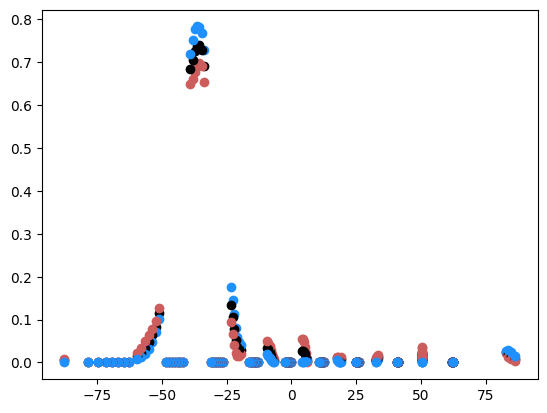

In [11]:
for i in range(len(theta_arr_45)):
    plt.scatter(theta_arr_45[i], eff_arr_45[i], color = 'k', label = 'unpolarized')
    plt.scatter(theta_arr[i], eff_arr[i], color = 'indianred', label = 'TM')
    plt.scatter(theta_arr_90[i], eff_arr_90[i], color = 'dodgerblue', label = 'TE')



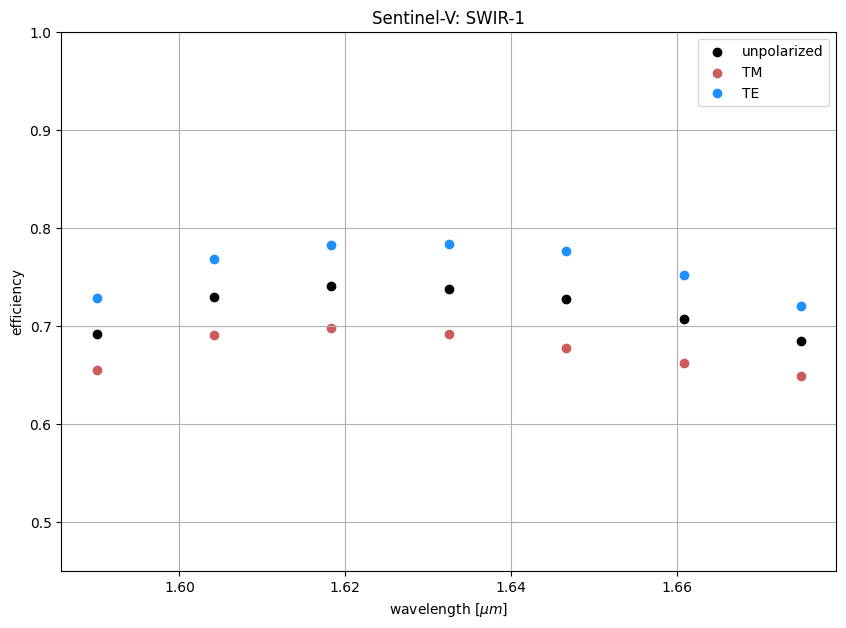

In [12]:

m=-6
eff_arr_mth = []
eff_arr_90_mth = []
eff_arr_45_mth = []
for i in range(len(wavelength_range)):
    eff_arr_mth.append(eff_arr[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_90_mth.append(eff_arr_90[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_45_mth.append(eff_arr_45[i][mthorder_angle(theta_arr[i], m)])

plt.figure(figsize=(10, 7))
plt.scatter(wavelength_range*1e6, eff_arr_45_mth, color = 'k', label = 'unpolarized')
plt.scatter(wavelength_range*1e6, eff_arr_mth, color = 'indianred', label = 'TM')
plt.scatter(wavelength_range*1e6, eff_arr_90_mth, color = 'dodgerblue', label = 'TE')
plt.ylim(0.45,1.0)
plt.title(f"Sentinel-V: SWIR-1")
plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'efficiency')
plt.legend()
plt.grid()

In [25]:
######## SWIR-1 CarbonSat ###############
# parameters for CarbonSat SWIR - 1
grating_params = {
    "period_grating": 2140e-9,  # Period of grating [m]
    "base_width": 1680e-9,      # Base width of etch [m]
    "height": 802e-9,          # Height of the etch [m]
    "angleB": 82.5,             # Angle B in degrees
    "angleA": 27.0,               # Angle A in degrees
    "incidence_angle": -32
    }


In [26]:
wavelength_range = np.linspace(1.590e-6, 1.675e-6, 17)
pol = 0
theta_arr = []
eff_arr = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr.append(theta_arr_i[:,0])
    eff_arr.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.590e-6, 1.675e-6, 17)
pol = 90

theta_arr_90 = []
eff_arr_90 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_90.append(theta_arr_i[:,0])
    eff_arr_90.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.590e-6, 1.675e-6, 17)
pol = 45

theta_arr_45 = []
eff_arr_45 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_45.append(theta_arr_i[:,0])
    eff_arr_45.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



done: wav = 1.59 microns
done: wav = 1.5953125000000001 microns
done: wav = 1.600625 microns
done: wav = 1.6059375 microns
done: wav = 1.61125 microns
done: wav = 1.6165625000000001 microns
done: wav = 1.621875 microns
done: wav = 1.6271875 microns
done: wav = 1.6325 microns
done: wav = 1.6378125000000001 microns
done: wav = 1.643125 microns
done: wav = 1.6484375 microns
done: wav = 1.65375 microns
done: wav = 1.6590625 microns
done: wav = 1.6643750000000002 microns
done: wav = 1.6696875 microns
done: wav = 1.675 microns
done: wav = 1.59 microns
done: wav = 1.5953125000000001 microns
done: wav = 1.600625 microns
done: wav = 1.6059375 microns
done: wav = 1.61125 microns
done: wav = 1.6165625000000001 microns
done: wav = 1.621875 microns
done: wav = 1.6271875 microns
done: wav = 1.6325 microns
done: wav = 1.6378125000000001 microns
done: wav = 1.643125 microns
done: wav = 1.6484375 microns
done: wav = 1.65375 microns
done: wav = 1.6590625 microns
done: wav = 1.6643750000000002 microns
do

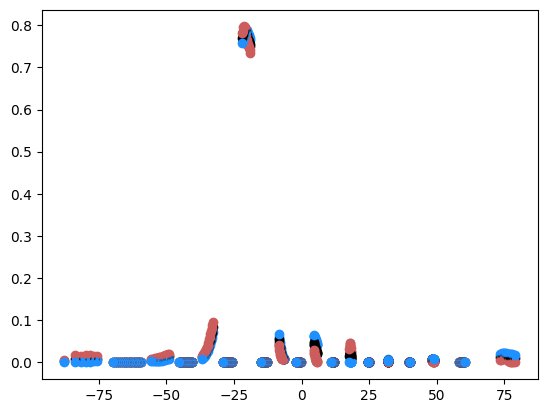

In [27]:
for i in range(len(theta_arr_45)):
    plt.scatter(theta_arr_45[i], eff_arr_45[i], color = 'k', label = 'unpolarized')
    plt.scatter(theta_arr[i], eff_arr[i], color = 'indianred', label = 'TM')
    plt.scatter(theta_arr_90[i], eff_arr_90[i], color = 'dodgerblue', label = 'TE')



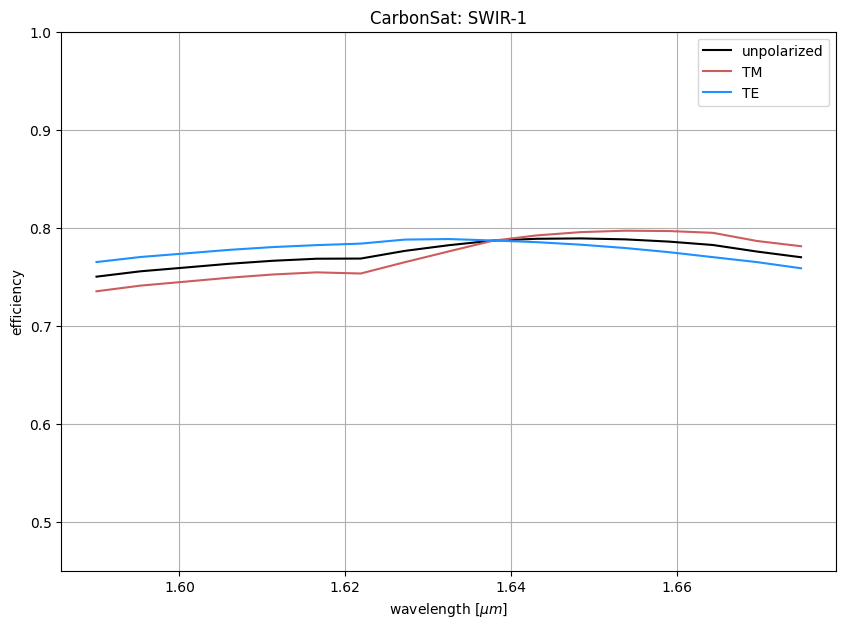

In [28]:
m=-4
eff_arr_mth = []
eff_arr_90_mth = []
eff_arr_45_mth = []
for i in range(len(wavelength_range)):
    eff_arr_mth.append(eff_arr[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_90_mth.append(eff_arr_90[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_45_mth.append(eff_arr_45[i][mthorder_angle(theta_arr[i], m)])

plt.figure(figsize=(10, 7))
plt.plot(wavelength_range*1e6, eff_arr_45_mth, color = 'k', label = 'unpolarized')
plt.plot(wavelength_range*1e6, eff_arr_mth, color = 'indianred', label = 'TM')
plt.plot(wavelength_range*1e6, eff_arr_90_mth, color = 'dodgerblue', label = 'TE')

plt.ylim(0.45,1.0)
plt.title(f"CarbonSat: SWIR-1")
plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'efficiency')
plt.legend()
plt.grid()

In [17]:
######## SWIR-2 CarbonSat ###############
# parameters for CarbonSat SWIR - 2
grating_params = {
    "period_grating": 2640e-9,  # Period of grating [m]
    "base_width": 2050e-9,      # Base width of etch [m]
    "height": 747.3e-9,          # Height of the etch [m]
    "angleB": 89.4,             # Angle B in degrees
    "angleA": 20.1,               # Angle A in degrees
    "incidence_angle": -23
    }


In [18]:
wavelength_range = np.linspace(1.925e-6, 2.095e-6, 7)
pol = 0
theta_arr = []
eff_arr = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr.append(theta_arr_i[:,0])
    eff_arr.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.925e-6, 2.095e-6, 7)
pol = 90

theta_arr_90 = []
eff_arr_90 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_90.append(theta_arr_i[:,0])
    eff_arr_90.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")


wavelength_range = np.linspace(1.925e-6, 2.095e-6, 7)
pol = 45

theta_arr_45 = []
eff_arr_45 = []


for i in range(len(wavelength_range)):
    theta_arr_i, eff_arr_i = immersed_grating_fdtd(wavelength_range[i], pol, **grating_params)
    
    theta_arr_45.append(theta_arr_i[:,0])
    eff_arr_45.append(eff_arr_i[:,0])

    print(f"done: wav = {wavelength_range[i]*1e6} microns")



done: wav = 1.9250000000000003 microns
done: wav = 1.9533333333333334 microns
done: wav = 1.9816666666666667 microns
done: wav = 2.0100000000000002 microns
done: wav = 2.0383333333333336 microns
done: wav = 2.0666666666666664 microns
done: wav = 2.0949999999999998 microns
done: wav = 1.9250000000000003 microns
done: wav = 1.9533333333333334 microns
done: wav = 1.9816666666666667 microns
done: wav = 2.0100000000000002 microns
done: wav = 2.0383333333333336 microns
done: wav = 2.0666666666666664 microns
done: wav = 2.0949999999999998 microns
done: wav = 1.9250000000000003 microns
done: wav = 1.9533333333333334 microns
done: wav = 1.9816666666666667 microns
done: wav = 2.0100000000000002 microns
done: wav = 2.0383333333333336 microns
done: wav = 2.0666666666666664 microns
done: wav = 2.0949999999999998 microns


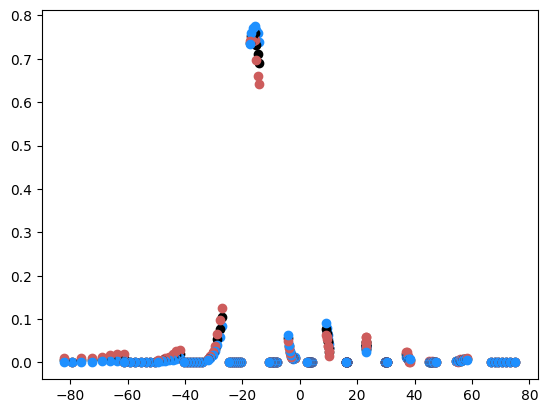

In [19]:
for i in range(len(theta_arr_45)):
    plt.scatter(theta_arr_45[i], eff_arr_45[i], color = 'k', label = 'unpolarized')
    plt.scatter(theta_arr[i], eff_arr[i], color = 'indianred', label = 'TM')
    plt.scatter(theta_arr_90[i], eff_arr_90[i], color = 'dodgerblue', label = 'TE')



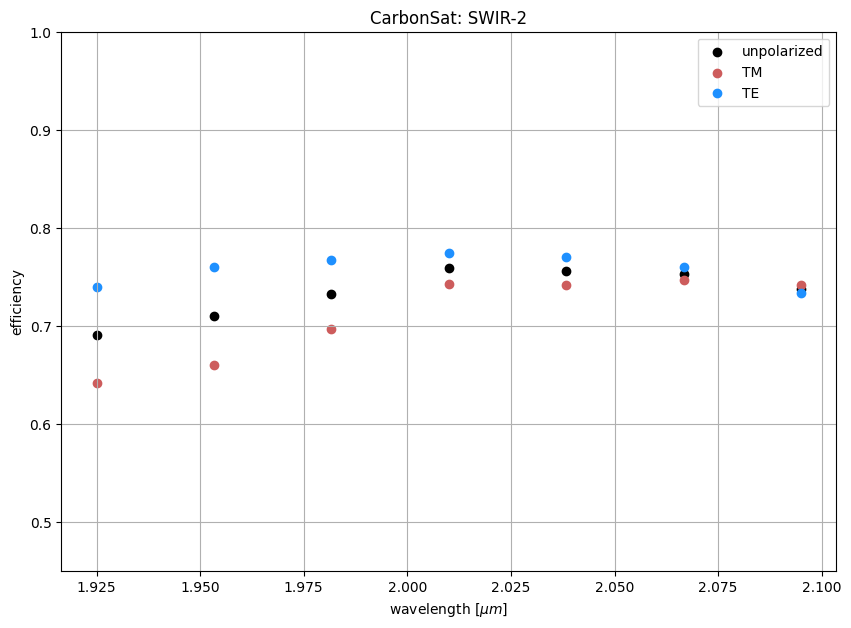

In [20]:

m=-3
eff_arr_mth = []
eff_arr_90_mth = []
eff_arr_45_mth = []
for i in range(len(wavelength_range)):
    eff_arr_mth.append(eff_arr[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_90_mth.append(eff_arr_90[i][mthorder_angle(theta_arr[i], m)])
    eff_arr_45_mth.append(eff_arr_45[i][mthorder_angle(theta_arr[i], m)])

plt.figure(figsize=(10, 7))
plt.scatter(wavelength_range*1e6, eff_arr_45_mth, color = 'k', label = 'unpolarized')
plt.scatter(wavelength_range*1e6, eff_arr_mth, color = 'indianred', label = 'TM')
plt.scatter(wavelength_range*1e6, eff_arr_90_mth, color = 'dodgerblue', label = 'TE')
plt.ylim(0.45,1.0)
plt.title(f"CarbonSat: SWIR-2")
plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'efficiency')
plt.legend()
plt.grid()